In [56]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [57]:
import numpy as np
import pandas as pd

In [58]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [59]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect, func

In [60]:
#Create the connection engine
engine =create_engine("sqlite:///Resources/hawaii.sqlite")

In [61]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [62]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [63]:
# Creating inspector and Collecting the names of tables within the database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [64]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')

for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [92]:
# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('station')

for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [65]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [66]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [67]:
# Retrieving Latest Date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23')

In [68]:
# Calculate the date 1 year ago from the last data point in the database
last_12months = (dt.date(2017, 8, 23)) - (dt.timedelta(days=365))
last_12months

datetime.date(2016, 8, 23)

In [69]:
# Perform a query to retrieve the date and precipitation values
lastyr_precip = session.query(Measurement.date, func.avg(Measurement.prcp)).\
    filter(Measurement.date >= last_12months).\
    group_by(Measurement.date).all()
                              
lastyr_precip

[('2016-08-23', 0.45166666666666666),
 ('2016-08-24', 1.5549999999999997),
 ('2016-08-25', 0.07714285714285715),
 ('2016-08-26', 0.016666666666666666),
 ('2016-08-27', 0.06399999999999999),
 ('2016-08-28', 0.5166666666666666),
 ('2016-08-29', 0.24333333333333332),
 ('2016-08-30', 0.011666666666666667),
 ('2016-08-31', 0.6359999999999999),
 ('2016-09-01', 0.006),
 ('2016-09-02', 0.05),
 ('2016-09-03', 0.254),
 ('2016-09-04', 0.276),
 ('2016-09-05', 0.08499999999999999),
 ('2016-09-06', 0.246),
 ('2016-09-07', 0.3333333333333333),
 ('2016-09-08', 0.07666666666666667),
 ('2016-09-09', 0.17833333333333332),
 ('2016-09-10', 0.27999999999999997),
 ('2016-09-11', 0.25),
 ('2016-09-12', 0.308),
 ('2016-09-13', 0.45166666666666666),
 ('2016-09-14', 2.3800000000000003),
 ('2016-09-15', 0.8266666666666667),
 ('2016-09-16', 0.11714285714285715),
 ('2016-09-17', 0.13599999999999998),
 ('2016-09-18', 0.10600000000000001),
 ('2016-09-19', 0.064),
 ('2016-09-20', 0.14714285714285716),
 ('2016-09-21', 

In [70]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(lastyr_precip, columns=['Date', 'Prcp (inches)'])
precip_df.set_index('Date', inplace=True)
precip_df.head()

,Prcp (inches)
Date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000


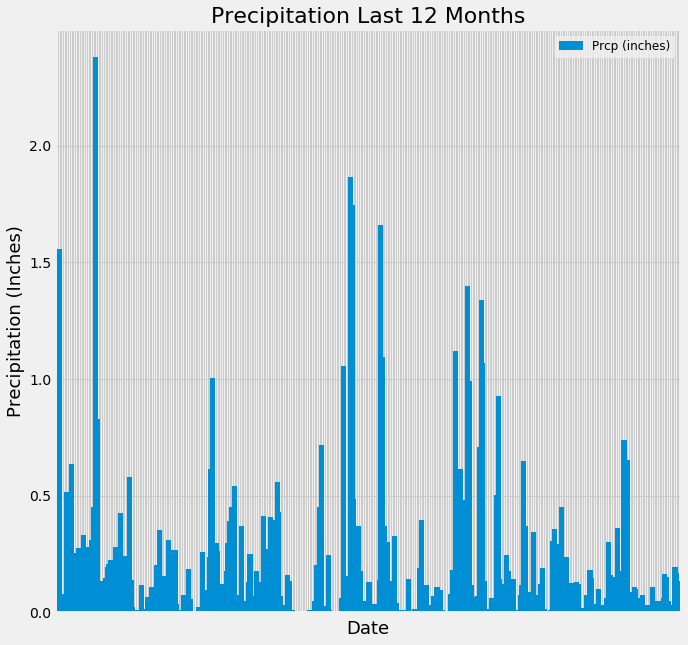

In [168]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df = precip_df.sort_values(by='Date',ascending=True)
precip_matplot= precip_df.plot(kind='bar', width=3, figsize=(10,10))
precip_matplot.xaxis.set_major_formatter(plt.NullFormatter())
plt.title("Precipitation Last 12 Months", size=22)
plt.ylabel("Precipitation (Inches)", size=18)
plt.xlabel("Date", size=18)
plt.legend(fontsize="12")
plt.grid(True)

plt.show()


In [169]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Prcp (inches)
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [170]:
# Design a query to show how many stations are available in this dataset
session.query(Station).group_by(Station.station).count()

9

In [172]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_active = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

station_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [173]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == station_active[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

In [110]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_high = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.station == station_active[0][0]).\
    filter(Measurement.date >= last_12months).all()

In [177]:
#Saving the station results with highest number of temp. observations in a Pandas DataFrame
tobs_high_df = pd.DataFrame(tobs_high, columns=['Station', 'Tobs'])
tobs_high_df.set_index('Station', inplace=True)
tobs_high_df.head(10)

,Tobs
Station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0
USC00519281,73.0
USC00519281,78.0
USC00519281,77.0
USC00519281,78.0


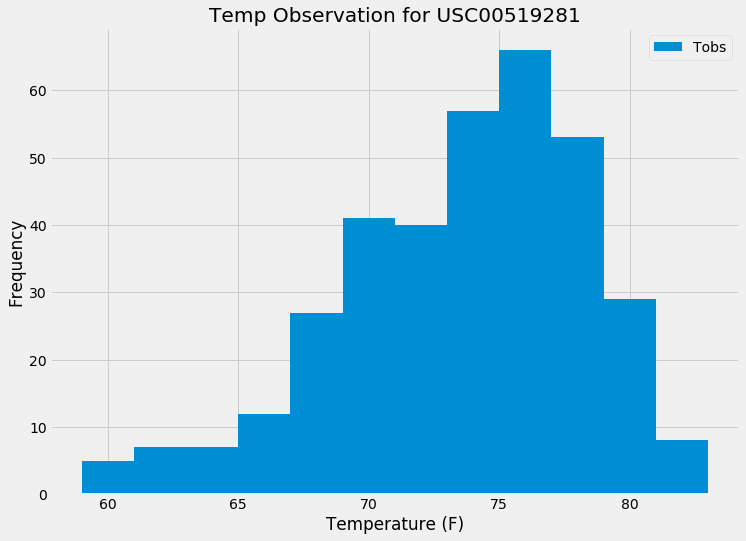

In [178]:
# Creating Histogram
tobs_high_df.plot.hist(by='station', bins=12, figsize=(11,8))
plt.title('Temp Observation for USC00519281')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

In [179]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [180]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_temps = calc_temps('2016-08-23', '2017-08-23')
trip_temps

[(58.0, 74.59058295964125, 87.0)]

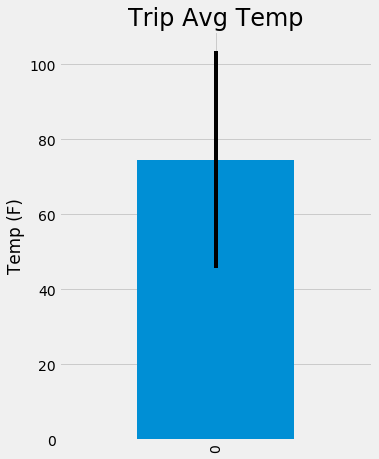

In [181]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temps_df = pd.DataFrame(trip_temps, columns=['tmin','tavg','tmax'])
average_temp = trip_temps_df['tavg']
average_temp.plot(kind='bar',yerr=trip_temps_df['tmax'] - trip_temps_df['tmin'], align='center',figsize=(5,7))
plt.title("Trip Avg Temp", fontsize=24)
plt.ylabel("Temp (F)")
plt.grid(True)

plt.show()
          

In [186]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def prcp_bystation(start_date, end_date):

    data_list= [Measurement.station, Station.name, Station.latitude, Station.longitude,
           Station.elevation, Measurement.prcp]

    return session.query(*data_list).\
        filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()
        
print(prcp_bystation('2016-08-23', '2017-08-23'))

[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.79), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.7), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.15), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.05), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.02), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


In [188]:
station_info = prcp_bystation('2016-08-23', '2017-08-23')
station_info

[('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.79),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.7),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.15),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.05),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.02),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

In [193]:
stationprec_df = pd.DataFrame(station_info, columns=['Measurement.station','Station.name','Station.latitude','Station.longitude','Station.elevation','Measurement.prcp'])
stationprec_df.set_index('Measurement.station', inplace=True)
stationprec_df

,Station.name,Station.latitude,Station.longitude,Station.elevation,Measurement.prcp
Measurement.station,,,,,
USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.79
USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.70
USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.15
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.05
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.02
USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00
USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN
